# Parse raw SPX data

In this notebook we import raw SPX data and make it usable for various tasks.

In [2]:
# Standard library imports
import numpy as np
import pandas as pd
import string
import os
from os.path import dirname as up

First, we get settlement prices for call and put options on the S&P 500 index from www.cboe.com/DelayedQuote/QuoteTableDownload.aspx and read calls and puts into separate dfs.

In [3]:
# Market parameters
spot_price = 2731.25
today = pd.to_datetime('20180215', format='%Y%m%d', errors='coerce')
nb_trading_days = 365

# Read in raw SPX data 
deep_cal_dir = up(up(os.getcwd()))
raw_df = pd.read_csv(deep_cal_dir + '/data/raw_data/spx_20180215.csv', skiprows=2)

# Separate puts and calls
df = raw_df.iloc[:,:7]
df2 = raw_df.iloc[:,7:]
del(raw_df)

# Drop superfluous columns
df.drop(['Last Sale', 'Net', 'Vol'], axis=1, inplace=True)
df2.drop(['Last Sale.1', 'Net.1', 'Vol.1', 'Unnamed: 14'], axis=1, inplace=True)
df2.columns = ['Puts', 'Bid', 'Ask', 'Open Int']

Extract information from ticker, write to separate df and then concatenate.

In [4]:
def extract_info_from_ticker(data):
    
    # Create a dictionary for conversion of month code (A-L: Jan-Dec for 
    # call, M-X: Jan-Dec for put) to MM
    letters = [letter for letter in string.ascii_uppercase[:24]]
    numbers = [nb for nb in range(1, 13)] + [nb for nb in range(1, 13)]
    cal_dict = dict(zip(letters,numbers))
    
    # Identify ticker from content
    ticker = str(data).split(' ')[3][1:-1]
    
    # Is option European or American?
    is_euro = True if ticker[-1] == 'E' else False
    
    # Is option Weekly?
    is_weekly = True if ticker[3] == 'W' else False
    
    # Differentiate between variables ticker lengths for Weekly and 
    # Standard options
    ticker = ticker[4:] if is_weekly else ticker[3:]
    
    # Detect time to maturity in years from ticker symbol.
    yy = '20'+ ticker[0:2]
    dd = ticker[2:4]
    mm = str(cal_dict[ticker[4]]).zfill(2)
    timestamp = pd.to_datetime(yy+mm+dd, format='%Y%m%d', errors='coerce')
    dtm = (timestamp - today).days
    dtm_frac = dtm/nb_trading_days
    
    # Detect moneyness from ticker symbol.
    strike = ticker[5:9]
    cont = True
    i = 0

    while cont:
        cont = strike[i].isdigit()
        if cont == False:
            strike = strike[:i]
        else:
            i += 1
            if i >= len(strike):
                break
    
    log_moneyness = np.log(int(strike)/spot_price)
    
    return is_euro, is_weekly, dtm_frac, log_moneyness, int(strike)

def parse_df(df, calls_or_puts):
    
    # Extract ticker information and store it.
    supp_df = df[calls_or_puts].apply(extract_info_from_ticker).apply(pd.Series)
    supp_df.columns = ['is_euro', 'is_weekly', 'time to maturity (years)', 
                       'log_moneyness', 'strike']
    
    supp_df.strike.astype('float64', copy=False)

    # Merge two dataframes
    df = pd.concat([df, supp_df], axis=1)
    
    # Drop the now redundant columns
    df.drop([calls_or_puts], axis=1, inplace=True)
    
    # Remove all but European options
    df = df[df['is_euro'] == True]
    df.drop(['is_euro'], axis=1, inplace=True)
    
    # Only consider Weeklys
    df = df[df['is_weekly'] == True]
    df.drop(['is_weekly'], axis=1, inplace=True)
    
    df['Mid'] = (df.Bid + df.Ask)/2
    
    return df

In [5]:
df = parse_df(df, 'Calls')
df2 = parse_df(df2, 'Puts') 

Export to .csv file for further tinkering.

In [5]:
# df.drop(['Bid', 'Ask'], axis=1, inplace=True)
df.to_csv(deep_cal_dir + '/data/raw_data/processed_spx_calls_all_liquids.csv')
df2.to_csv(deep_cal_dir + '/data/raw_data/processed_spx_puts_all_liquids.csv')

### Liquidity concerns

Use *open interest* and *inverse bid ask spread* as liquidity proxies and drop all options where liquidity is 0.

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import StrMethodFormatter

def set_style():

    sns.set_context("paper")

    sns.set(font='serif')
    
    sns.set_style("white", {
        "font.family": "serif",
        "font.serif": ["Times", "Palatino", "serif"]
    })

set_style()
%matplotlib inline

In [7]:
# Open interest
df = df[df['Open Int'] != 0]
df2 = df2[df2['Open Int'] != 0]

# Inverse bid ask spread
df["inv_spread"] = 1/(df.Ask - df.Bid)
df2["inv_spread"] = 1/(df2.Ask - df2.Bid)

df.sort_values('inv_spread', inplace=True, ascending=True)
df2.sort_values('inv_spread', inplace=True, ascending=True)

In the following plot we can see that large parts of the parameter region have little liquidity.

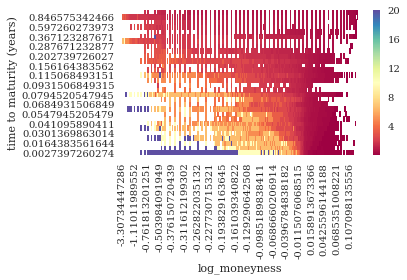

In [13]:
def plot_heatmap_by_liquidity(df, filename):

    oi_pivot_df = df.pivot(index='time to maturity (years)', 
                           columns='log_moneyness', values='inv_spread')

    ax = sns.heatmap(oi_pivot_df, cmap=plt.cm.Spectral, cbar=True, xticklabels=15, yticklabels=2)
    ax.invert_yaxis()

    plt.tight_layout()
    fig = plt.gcf()
    fig.savefig(filename)

filename = deep_cal_dir +'/data/raw_data/liquidity_bid_ask_spread/spx_liquidity_heatmap_complete_puts.pdf'
plot_heatmap_by_liquidity(df2, filename)

We thus reduce the parameter region of the calls considered to $-0.1\leq$ log_moneyness $\leq 0.28$ and $1/365\leq$ time to maturity $\leq 0.2$ and plot another heatmap.

In [8]:
df = df[df['log_moneyness'] <= 0.28]
df = df[df['log_moneyness'] >= -0.1]
df = df[df['time to maturity (years)'] <= 0.2]
df = df[df['time to maturity (years)'] >= 1/365]

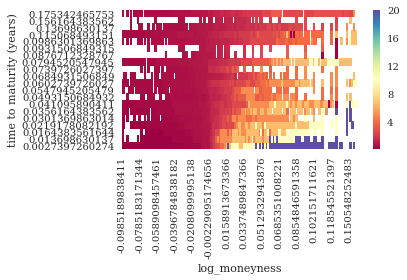

In [17]:
oi_pivot_df = df.pivot(index='time to maturity (years)', 
                       columns='log_moneyness', values='inv_spread')

ax = sns.heatmap(oi_pivot_df, xticklabels=10, cmap=plt.cm.Spectral)
ax.invert_yaxis()

plt.tight_layout()
fig = plt.gcf()
fig.savefig(deep_cal_dir + '/data/raw_data/liquidity_bid_ask_spread/spx_liquidity_heatmap_reduced_calls.pdf')

In [9]:
df.head(5)

,Bid,Ask,Open Int,time to maturity (years),log_moneyness,strike,Mid,inv_spread
1909,247.5,264.9,1,0.021918,-0.098519,2475,256.20,0.057471
2611,248.2,265.5,344,0.035616,-0.098519,2475,256.85,0.057803
1911,242.4,259.6,1,0.021918,-0.096501,2480,251.00,0.058140
1919,225.1,238.7,65,0.021918,-0.088469,2500,231.90,0.073529
1935,185.3,198.5,90,0.021918,-0.072595,2540,191.90,0.075758


Export to .csv file for further tinkering. 

In [20]:
# df.drop(['Bid', 'Ask'], axis=1, inplace=True)
df.sort_values('inv_spread', inplace=True, ascending=False)
df.to_csv(deep_cal_dir + '/data/raw_data/liquidity_bid_ask_spread/spx_liquid_calls.csv')

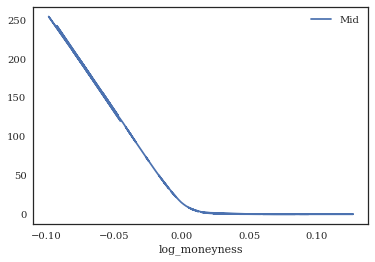

In [16]:
a = df['time to maturity (years)'].unique()[2]
df[df['time to maturity (years)'] == a].plot(x='log_moneyness', y='Mid')